In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from importlib import reload
import functions_model_eval_val as f
reload(f)

<module 'functions_model_eval_val' from 'e:\\Pima-Diabetes-Prediction\\notebooks\\functions_model_eval_val.py'>

In [70]:
df = pd.read_csv('../data/processed/data_remove_yes_balance_yes_scale_no.csv')

## Model Optimization

In [71]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='outcome'), df['outcome'], test_size=0.2, stratify=df['outcome'], random_state=42)

### Hyperparameter Tuning

In [72]:
param_grids = {
    "LogisticRegression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
        "max_iter": [100, 200, 300],
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
        "leaf_size": [20, 30, 40]
    },
    "DecisionTreeClassifier": {
        "max_depth": [None, 5, 10, 15, 20],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
    },
    "RandomForestClassifier": {
        "n_estimators": [100, 200, 300, 500],  # Valores más altos pueden estabilizar mejor el bosque
        "max_depth": [None, 10, 20, 30, 50],   # Agrego más profundidad por si el dataset es complejo
        "min_samples_split": [2, 5, 10],       # Está bien como está
        "min_samples_leaf": [1, 2, 4],         # También bien, controla regularización
        "max_features": ["sqrt", "log2", None], # Permite variar cómo se seleccionan features en cada split
        "bootstrap": [True, False],           # OK
        "criterion": ["gini", "entropy"],     # ⚠️ Elimina "log_loss" (solo funciona con `predict_proba`, y en RF no es común)
        "class_weight": [None, "balanced"],   # Si tienes clases desbalanceadas, esto es muy útil
    },
    "GaussianNB": {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    "BaggingClassifier": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.75, 1.0],
        "max_features": [0.5, 1.0],
        "bootstrap": [True, False]
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0]
    },
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.5, 1.0, 1.5]
    },
    "XGBClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [1, 2, 5, 10]  # Para clases desbalanceadas
    },
    "LGBMClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "num_leaves": [15, 31, 63],
        "boosting_type": ["gbdt", "dart"],
        "feature_fraction": [0.8, 1.0],
    }
}

In [73]:
models = {
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GaussianNB": GaussianNB(),
    "BaggingClassifier": BaggingClassifier(
        estimator=DecisionTreeClassifier()
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(
        estimator=DecisionTreeClassifier()
    ),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier(verbose=-1)
}

In [74]:
classification_metrics_pro, proba_predictions_dict_pro, models_pro = f.classification_hyperparameter_tuning(x_train, y_train, x_test, y_test, models, param_grids, n_iter=100, cv=5, scoring='f1')

Tuning hyperparameters for LogisticRegression...
Best hyperparameters for LogisticRegression:
{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 10} 

Tuning hyperparameters for KNeighborsClassifier...
Best hyperparameters for KNeighborsClassifier:
{'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean', 'leaf_size': 20} 

Tuning hyperparameters for DecisionTreeClassifier...
Best hyperparameters for DecisionTreeClassifier:
{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'gini'} 

Tuning hyperparameters for RandomForestClassifier...
Best hyperparameters for RandomForestClassifier:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True} 

Tuning hyperparameters for GaussianNB...
Best hyperparameters for GaussianNB:
{'var_smoothing': 1e-09} 

Tuning hyperparameters for BaggingClassifier...
Best hyperparame

### Model Evaluation (Pro)

#### Classification Metrics

In [75]:
classification_metrics_pro.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,LogisticRegression Pro,0.865,0.868687,0.86,0.864322,0.93240,0.936485
4,GaussianNB Pro,0.855,0.838095,0.88,0.858537,0.91860,0.919653
2,DecisionTreeClassifier Pro,0.845,0.887640,0.79,0.835979,0.90220,0.896776
6,GradientBoostingClassifier Pro,0.830,0.836735,0.82,0.828283,0.91910,0.924574
8,XGBClassifier Pro,0.820,0.796296,0.86,0.826923,0.92080,0.933516
3,RandomForestClassifier Pro,0.830,0.851064,0.80,0.824742,0.93180,0.942351
9,LGBMClassifier Pro,0.820,0.813725,0.83,0.821782,0.91890,0.929306
1,KNeighborsClassifier Pro,0.820,0.833333,0.80,0.816327,0.91400,0.928530
5,BaggingClassifier Pro,0.820,0.855556,0.77,0.810526,0.90665,0.928002
7,AdaBoostClassifier Pro,0.775,0.783505,0.76,0.771574,0.77500,0.715464


In [76]:
best_models = classification_metrics_pro.sort_values(by='F1 Score', ascending=False).head(4)['Model'].values

#### Confusion Matrix

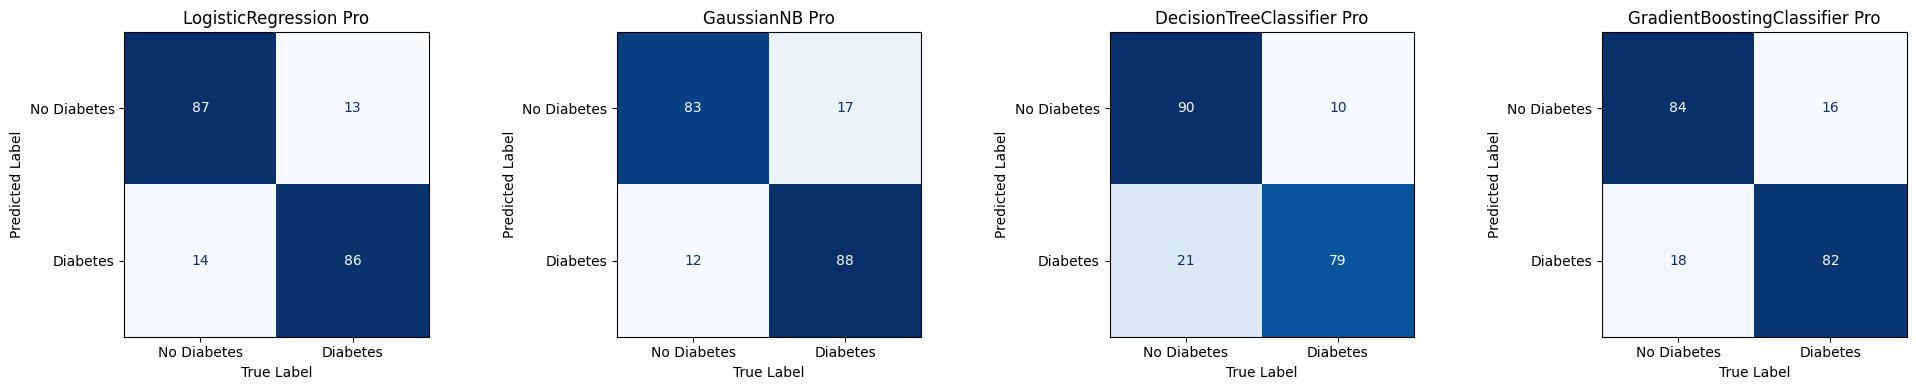

In [77]:
f.display_confusion_matrix(proba_predictions_dict_pro, models = best_models, labels = ['No Diabetes', 'Diabetes'], cmap = 'Blues', models_per_row=4)

#### ROC Curve

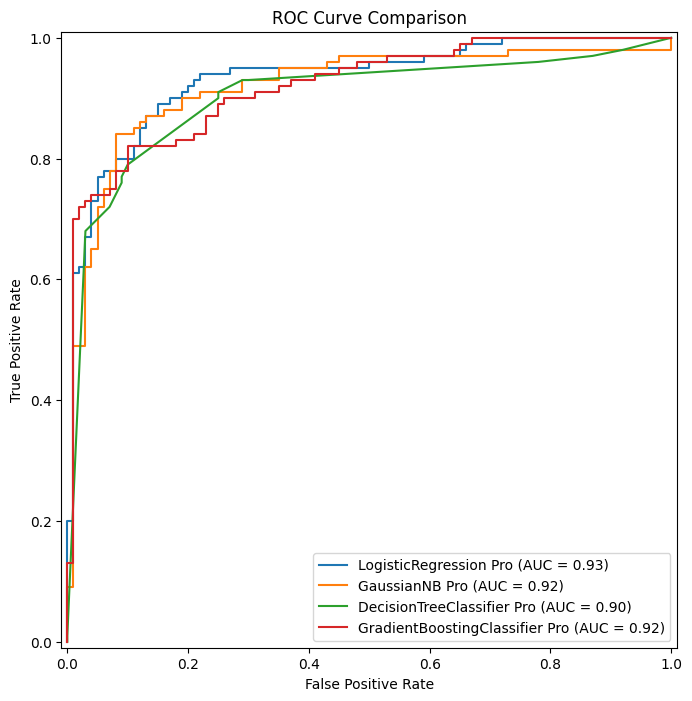

In [78]:
f.display_roc_curves(proba_predictions_dict_pro, models=best_models)

#### Precision-Recall Curve

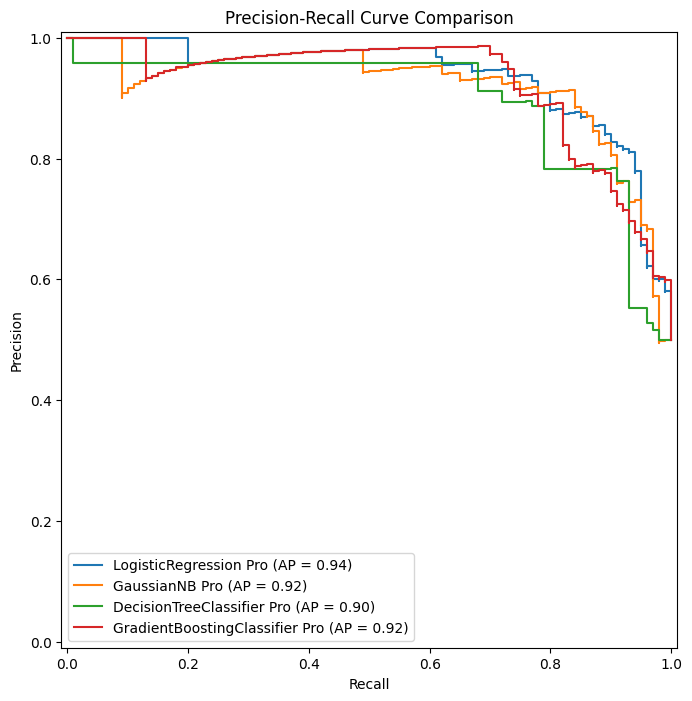

In [79]:
f.display_precision_recall_curve(proba_predictions_dict_pro, models=best_models)

### Model Validation (Pro)

#### K-Fold Validation

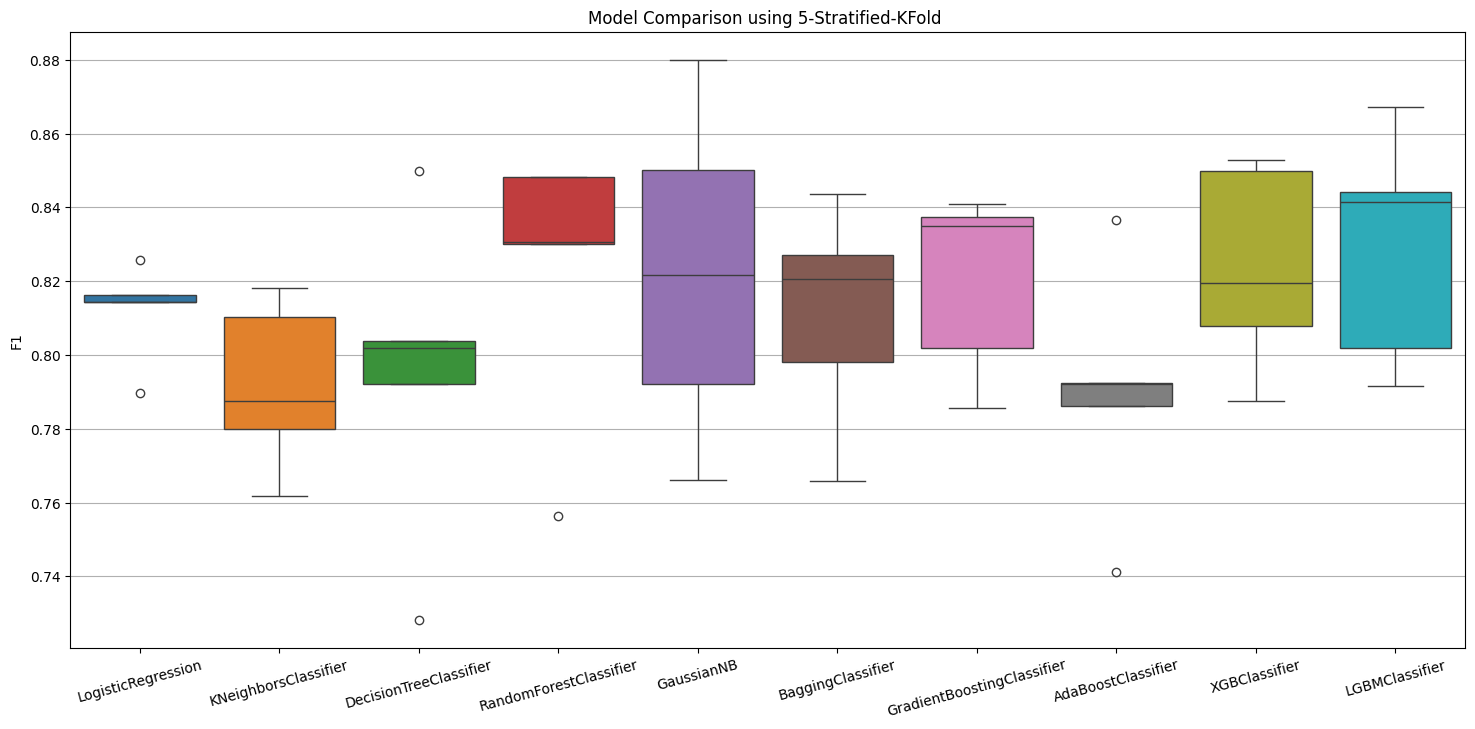

In [80]:
f.evaluate_models_with_kfold(models, df.drop(columns='outcome'), df['outcome'], cv=5, scoring='f1')

#### Learning Curve

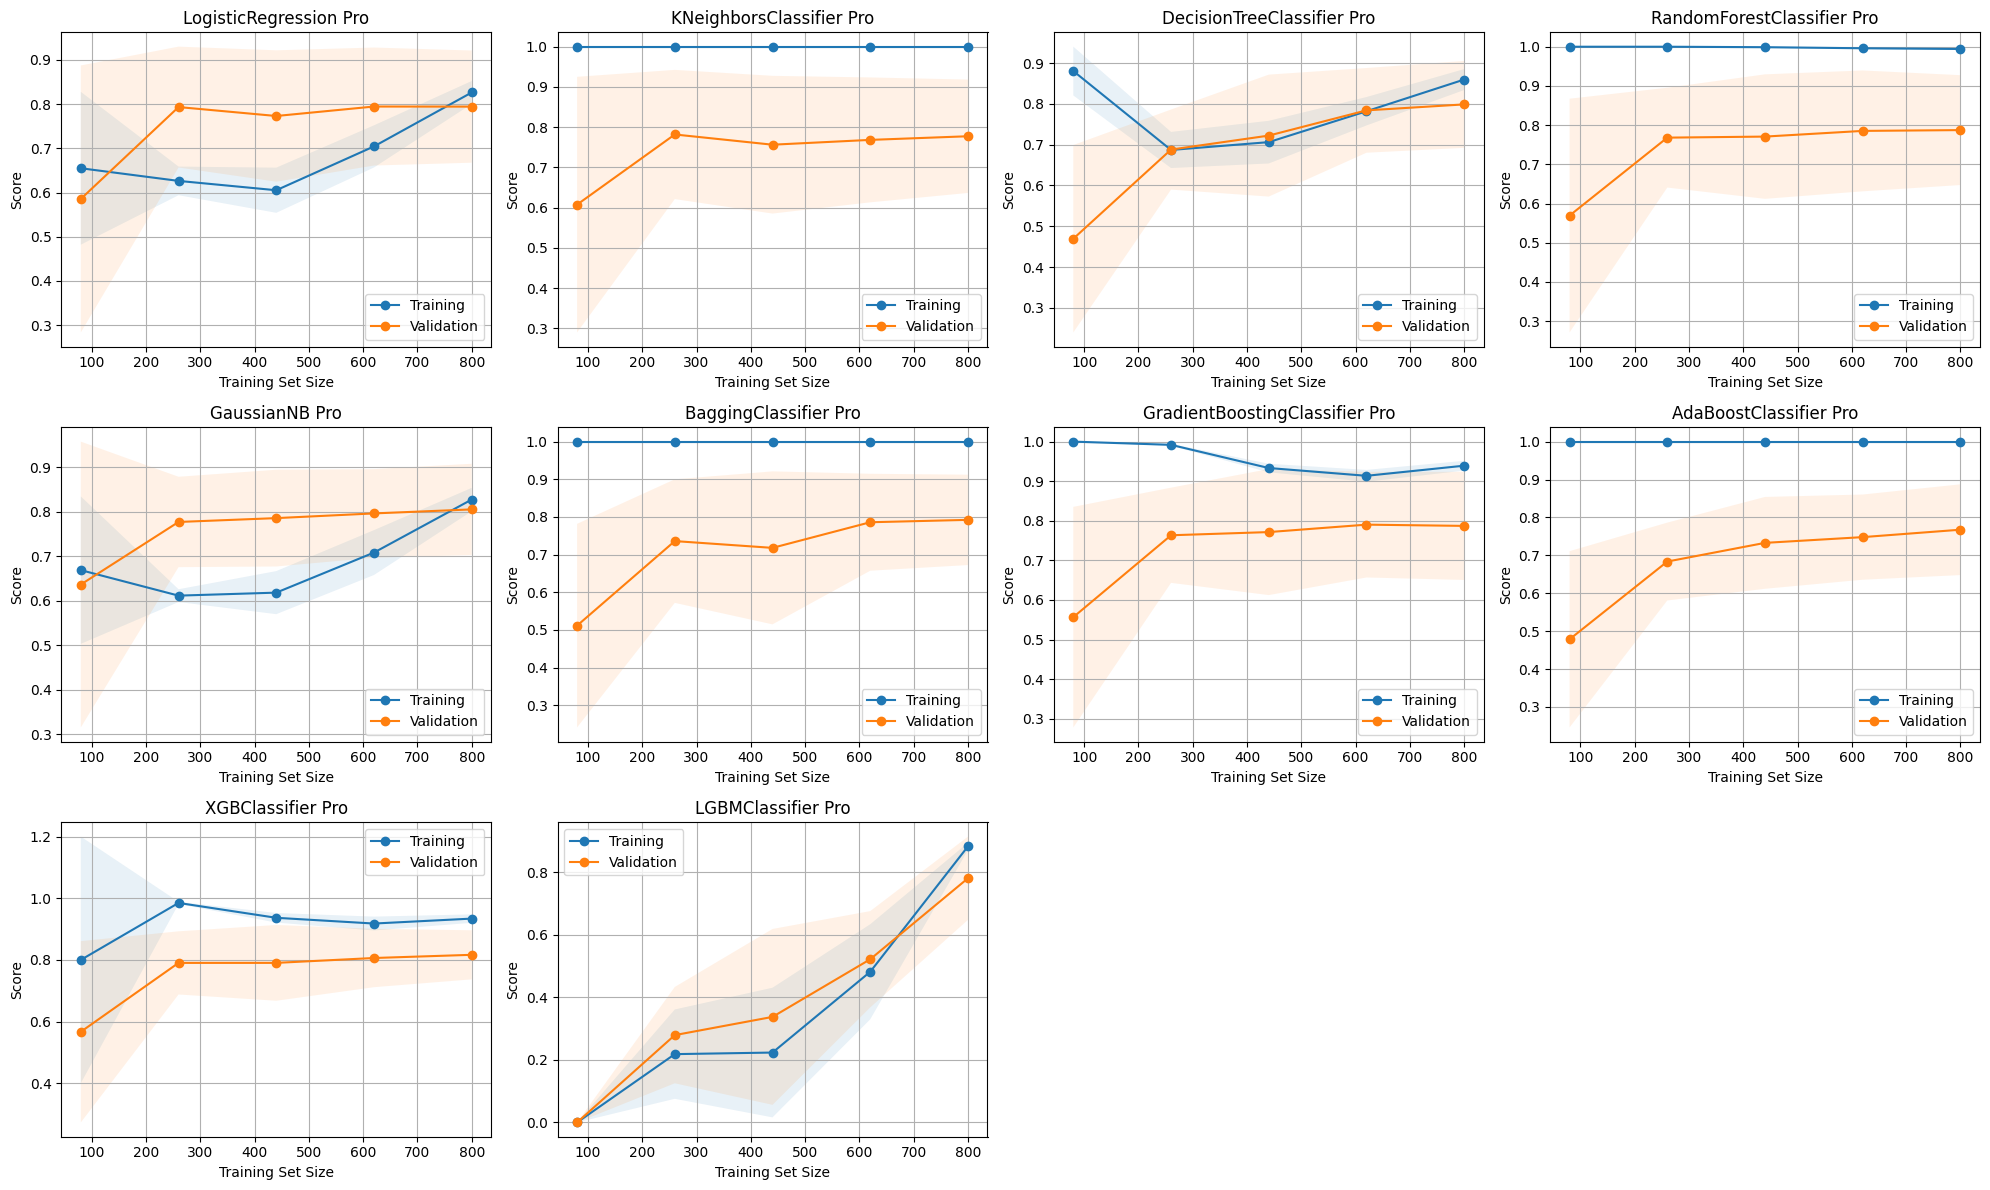

In [81]:
f.plot_learning_curves(models_pro, df.drop(columns='outcome'), df['outcome'], cv=5, scoring='f1', n_jobs=1)

In [84]:
best_model = models_pro["LogisticRegression Pro"]
print(best_model)

LogisticRegression(C=10, penalty='l1', solver='liblinear')


In [85]:
from joblib import dump

dump(best_model, '../models/best_model.pkl')

['../models/best_model.pkl']